In [2]:
!ls bearing_fatigue_dataset/

AccB_1_1.pickle  AccB_2_1.pickle  AccB_3_1.pickle
AccB_1_2.pickle  AccB_2_2.pickle  AccB_3_2.pickle
AccB_1_3.pickle  AccB_2_3.pickle  AccB_3_3.pickle
AccB_1_4.pickle  AccB_2_4.pickle  inspect_preproc.ipynb
AccB_1_5.pickle  AccB_2_5.pickle  phm-ieee-2012-data-challenge-dataset
AccB_1_6.pickle  AccB_2_6.pickle  preproc_stage_1.py
AccB_1_7.pickle  AccB_2_7.pickle


## Adversarial learning on the FEMTO accelerated fatigue bearing dataset
The dataset is associated with a challenge for the PHM conference on 2012.
The motivation of this work is to investigate if and when adversarial learning on raw time-series performs well. The hypotheses of this work are the following:

* **Dilated DenseNets** are flexible enough to work with raw time-series (this is not an established fact in SHM applications)
* Adversarial learning can be used to normalize implicitly for **domain shifts** without manual intervention. 

The following need to be performed:
* Preprocessing (making the dataset appropriate for training with the adversarial densenet - domain labels etc)
* Train/test splitting for the raw accelerometer time-series
* write the optimization loop
* run prelim. experiments - hopefully something will fit. 
* write code for performing 1-vs-rest experiments to test generalization.

In [1]:
import tensorflow as tf
#tf.enable_eager_execution()
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as pplot
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, AveragePooling1D, GlobalAveragePooling1D, Flatten, BatchNormalization, Dropout

import os

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)
#tf.keras.backend.set_session(sess)
#from tensorflow.math import confusion_matrix

In [2]:
tf.__version__

'2.1.0'

In [3]:
from src.dilated_densenet_adversarial import make_model, make_densenet_parametrization_dictionary

In [4]:
def calc_receptive_field(Nd, Nf, conv_type = "causal"):
    "returns the number of input taps each layer in a dilated caysal conv stack sees."
    if conv_type == "causal":
        corr = [0]+[1]*(len(Nd)-1)#correction for double counted neurons.
    
    return np.cumsum([(nf_) * (nd_) - (nd_-1) - c for nf_, nd_ ,c in zip(Nf, Nd, corr)])  #- (len(Nd)) + 1

calc_receptive_field([2**n for n in range(10)],[2]*10)
calc_receptive_field([3**n for n in range(10)],[3]*10)

calc_receptive_field([2,4,8,16,32,64,128,512], [3]*5)*5

array([ 25,  65, 145, 305, 625])

In [183]:
from src.util import plot_confusion_matrix
from src.experiments_utils import *

ndn = 4
ndn2 = 5

experiment_parametrization = {
    'dilation_rates_dn1': [2,4,8,16,32,64,128,512,8,16,32,64,128,512][0:ndn],#,4,8,16,32],
    'kernel_sizes_dn1' :  [3] * ndn,#,5,5],
    'nfilters_dn1' :  [50]*ndn,
    'dilation_rates_dn2' : [2]*ndn2,
    'kernel_sizes_dn2' : [5]*ndn2,
    'nfilters_dn2': [10]*ndn2
}

make_network_description_experiments_A(**experiment_parametrization)
model_json = make_network_json_experiments_A(**experiment_parametrization)
#

model_json['classifier']['network_layers'][0]['params']['units'] = 640
model_json["densenet_1d"]["network_layers"][0]["params"]["Variational"] = False
model_json["densenet_1d"]["network_layers"][0]['params']["dropout_after_composite"] = 0.1
model_json["densenet_1d"]["network_layers"] = [
    model_json["densenet_1d"]["network_layers"][0],model_json["densenet_1d"]["network_layers"][-1]
]
model_json['inputs'][0]['shape'] = (2559,2)
model_json['domain_classifier']['network_layers'][-1]['params']['units'] = 17
# Make the model act as a regressor:
model_json['classifier']['network_layers'][-1]['params']['units'] = 1
model = make_model(model_json)

Tensor("DN_DN1_ConcatOut_6/Identity:0", shape=(None, 2559, 400), dtype=float32)


In [184]:
model_json

{'inputs': [{'type': 'timeseries',
   'help_string': '(required) the timeseries input for the layer.',
   'id': 'timeseries_input',
   'shape': (2559, 2)}],
 'densenet_1d': {'network_layers': [{'type': 'densenet_block',
    'id': 'DN1',
    'help_string': 'Parametrization for a `densenet_block`',
    'params': {'filters': [50, 50, 50, 50],
     'dilation_rates': [2, 4, 8, 16],
     'kernel_sizes': [3, 3, 3, 3],
     'Variational': False,
     'dropout_after_composite': 0.1,
     'internal_bottleneck_factor': 1}},
   {'type': 'final_pooling', 'id': 'FinalPooling'}]},
 'domain_classifier': {'network_layers': [{'type': 'Dense',
    'params': {'units': 100, 'activation': 'relu', 'use_bias': True}},
   {'type': 'Dropout', 'params': {'rate': 0.2}},
   {'type': 'Dense',
    'id': 'domain_output',
    'params': {'units': 17, 'name': 'ExpID'}}]},
 'classifier': {'network_layers': [{'type': 'Dense',
    'params': {'units': 640, 'activation': 'relu', 'use_bias': True}},
   {'type': 'Dropout', 'pa

In [35]:
model.summary()
inspect_ddout = Model(inputs = model.get_layer("timeseries_input").input,outputs = model.get_layer("DN_DN1_Out").output)


Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
timeseries_input (InputLayer)   [(None, 2559, 2)]    0                                            
__________________________________________________________________________________________________
DN_DN1_C1D (Conv1D)             (None, 2559, 50)     150         timeseries_input[0][0]           
__________________________________________________________________________________________________
DN_DN1_idx_0 (Sequential)       (None, 2559, 50)     10100       DN_DN1_C1D[0][0]                 
__________________________________________________________________________________________________
DN_DN1_idx_1 (Sequential)       (None, 2559, 50)     10100       DN_DN1_idx_0[0][0]               
                                                                 DN_DN1_C1D[0][0]          

In [36]:
#model.load_weights("/tmp/bearing_fatigue_predictor_weights.pkl")
#model.load_weights("model_closs0.00")
#keras.load_weights("model_closs0.00")

In [37]:
#res = inspect_ddout(X[eid == 0][0::10])

In [38]:
def pad_vals(xin, pad_start = 0, pad_end = None,seg_start = 100, seg_end = 500):
    pad_end = xin.shape[1] - pad_start;
    return np.hstack([np.zeros([1,pad_start,2]),xin[0:1,seg_start:seg_end], np.zeros([1,pad_end,2])])

if False:
    vv_hist=  [];
    for pad_start in [100, 200, 300,400,500,600]:
        vv = inspect_ddout(pad_vals(X[0:1],pad_start = pad_start))
        vv_hist.append(vv)
        pplot.pcolor(vv[0][::5,::5].numpy().T)
        pplot.show()

In [39]:
if False:
    for ii in range(0,17):
        vv = model.predict(X[eid == ii])

        pplot.plot(vv[1], label = 'predicted cycles')
        pplot.plot(yrem_norm[eid == ii], label = 'true remaining %i')
        pplot.title("Experiment %s"%all_files[ii])

        pplot.show()
#pplot.plot(np.mean(vv_hist[0][:,0:][0].numpy()[:,::1].T,0))
#pplot.show()
#pplot.plot(np.mean(vv_hist[5][:,0:][0].numpy()[:,::1].T,0))
#pplot.plot(vv_hist[1][:,0:600][0].numpy()[:,::1].T)

In [40]:
#from sklearn.decomposition import PCA
#pca = PCA(n_components=2)
#pca.fit_transform()
#model.predict(X[eid == 1][0:100,:])[0]
#model.predict(X[eid == 1][:,0:1000,:])

In [41]:
## A helper function to return the pooling layer (the feature detector output) of a network:
get_global_pool_layer = lambda mm : mm.get_layer([l.name for l in mm.layers if 'global_average' in l.name][0])


In [42]:
import pandas as pd
import matplotlib.pyplot as pplot
import numpy as np


In [43]:
all_files = [f for f in os.listdir(os.path.join('bearing_fatigue_dataset')) if 'pickle' in f]

In [44]:
!ls bearing_fatigue_dataset/phm-ieee-2012-data-challenge-dataset/Learning_set/

Bearing1_1  Bearing1_2	Bearing2_1  Bearing2_2	Bearing3_1  Bearing3_2


In [45]:
def load_bearings_dataset(all_files = all_files):
    fnames = all_files
    exp_ids_tot = [];
    yrem_tot = [];
    sensor_values_tot = []

    for kk,fname in enumerate(fnames):
        p1 = pd.read_pickle("bearing_fatigue_dataset/%s"%fname)
        p1['abs_timestamp'] = (p1['h']*60+p1['m'])*60+p1['s']+p1['se-6']/1e6
        sensors = p1.groupby("block").apply(lambda x : [x['abs_timestamp'].mean(),np.vstack([x['h_acc'].values, x['v_acc'].values]).T])
        sens_val = np.dstack([v[1] for v in sensors.values])
        sensor_values = np.swapaxes(np.swapaxes(sens_val,0,-1),1,2).astype('float32')
        print(sensor_values.shape)
        
        yrem = np.vstack([v[0] for v in sensors.values]).astype('float32')
        yrem = np.abs(yrem - np.max(yrem))

        exp_id = np.hstack([kk for v in range(yrem.shape[0])])

        sensor_values_tot.append(sensor_values)
        exp_ids_tot.append(exp_id);
        yrem_tot.append(yrem)

        print(kk)

    yrem_tot = np.vstack(yrem_tot).flatten()
    eid = np.hstack(exp_ids_tot).flatten()
    X = np.vstack(sensor_values_tot)
    return yrem_tot, eid, X
yrem_s_raw, eid, X = load_bearings_dataset()


(172, 2559, 2)
0
(1502, 2559, 2)
1
(1637, 2559, 2)
2
(515, 2559, 2)
3
(871, 2559, 2)
4
(1802, 2559, 2)
5
(2302, 2559, 2)
6
(1202, 2559, 2)
7
(1139, 2559, 2)
8
(2002, 2559, 2)
9
(572, 2559, 2)
10
(352, 2559, 2)
11
(797, 2559, 2)
12
(911, 2559, 2)
13
(612, 2559, 2)
14
(2803, 2559, 2)
15
(2302, 2559, 2)
16


In [46]:
yrem = [];
for ee in np.unique(eid):
    yelapsed_ = np.cumsum(yrem_s_raw[eid == ee])
    yrem_ = np.max(yelapsed_) - yelapsed_;
    yrem.append(yrem_)
yrem = np.hstack(yrem)

## Taking data from the end
In order to 

* ballance the classes
* have time-series with more features related to failure

the time-series is truncated closer to the failure of the specimens.

In [47]:
if False:
    # trim the dataset closer to failure for ballancing 
    pplot.plot(yrem[yrem<500000],'.')
    yrem,yrem_s_raw, eid, X = [yrem[yrem<500000],yrem_s_raw[yrem<500000], eid[yrem<500000], X[yrem<500000]]

## Train-test splitting:

In [48]:
eid_oh = np.zeros([eid.shape[0],np.max(eid) + 1])
for k in np.unique(eid):
    eid_oh[eid == k,k] = 1.;

In [49]:
from sklearn.model_selection import train_test_split
yrem_norm = yrem / np.std(yrem);
x_train, x_test, y_train, y_test, d_train, d_test = train_test_split(X, yrem_norm, eid_oh, stratify = eid_oh)

In [50]:
X.shape

(21493, 2559, 2)

In [51]:
from ipywidgets import IntSlider, interact
@interact(ii_ = IntSlider(min = 0,max = X.shape[0], step = 100))
def ii(ii_):
    pplot.plot(X[ii_])
    
    pplot.ylim([-5,5])
    print(yrem[ii_], eid[ii_])

interactive(children=(IntSlider(value=0, description='ii_', max=21493, step=100), Output()), _dom_classes=('wi…

In [52]:
# split_files by operating conditions:
operating_conditions = ['1','2','3'];
files_per_condition = {oc : [(f,idx, np.max(yrem_s_raw[eid == idx])) for idx,f in enumerate(all_files) if f[5] == oc] for oc in operating_conditions}
files_per_condition

{'1': [('AccB_1_7.pickle', 1, 15010.0),
  ('AccB_1_2.pickle', 4, 8700.0),
  ('AccB_1_3.pickle', 5, 18010.002),
  ('AccB_1_5.pickle', 6, 23010.0),
  ('AccB_1_4.pickle', 8, 11380.002),
  ('AccB_1_1.pickle', 15, 28072.203),
  ('AccB_1_6.pickle', 16, 23010.0)],
 '2': [('AccB_2_7.pickle', 0, 1710.0),
  ('AccB_2_3.pickle', 7, 12010.0),
  ('AccB_2_5.pickle', 9, 20010.0),
  ('AccB_2_6.pickle', 10, 5710.0),
  ('AccB_2_2.pickle', 12, 7960.0),
  ('AccB_2_1.pickle', 13, 9100.0),
  ('AccB_2_4.pickle', 14, 6110.0)],
 '3': [('AccB_3_2.pickle', 2, 16360.0),
  ('AccB_3_1.pickle', 3, 5140.0),
  ('AccB_3_3.pickle', 11, 3510.0)]}

In [53]:
#pplot.plot(model.get_layer("DN_DN1_C1D").get_weights()[0][0])
#c1 = model.get_layer("DN_DN1_C1D")
#model.summary()
#c2 = model.get_layer("global_average_pooling1d")
#insp_inp = Input(shape = (400,2))
#c1(insp_inp)
#inspect_2 = keras.Model(inputs = c1(insp_inp), outputs = c2.output)

## Training


In [54]:
feature_extractor = keras.Model(inputs = model.inputs, outputs = get_global_pool_layer(model).output)

In [55]:
np.argmax(d_train,1)

array([ 9, 16, 15, ...,  1, 13, 15])

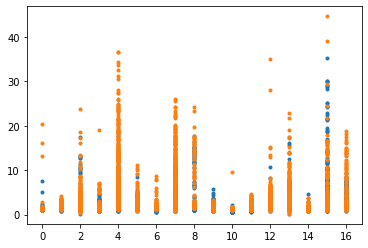

In [189]:
#pplot.plot(np.argmax(d_train,0),np.std(x_train,0))
pplot.plot(np.argmax(d_train,1),np.max(x_train,1),'.')

In [56]:
#feature_extractor(x_train[0:10]).eval()
#y_train = (y_train)/np.std(y_train)
#y_test = (y_test)/np.std(y_test)


In [148]:
y_h = feature_extractor.predict(x_train, batch_size=20)


Train on 16119 samples, validate on 5374 samples
Epoch 1/50
custom grad
custom grad
16100/16119 [============================>.] - ETA: 0s - loss: 0.7872 - ExpID_loss: 2.8235 - Y_output_loss: 0.7872

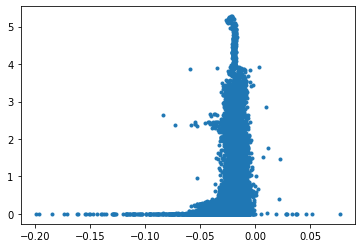

16119/16119 [==============================] - 48s 3ms/sample - loss: 0.7875 - ExpID_loss: 2.8236 - Y_output_loss: 0.7880 - val_loss: 0.7879 - val_ExpID_loss: 2.8234 - val_Y_output_loss: 0.7874
Epoch 2/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.6201 - ExpID_loss: 2.8243 - Y_output_loss: 0.6201

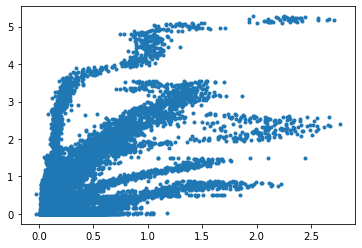

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.6197 - ExpID_loss: 2.8244 - Y_output_loss: 0.6191 - val_loss: 0.5702 - val_ExpID_loss: 2.8350 - val_Y_output_loss: 0.5696
Epoch 3/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.4397 - ExpID_loss: 2.8495 - Y_output_loss: 0.4397

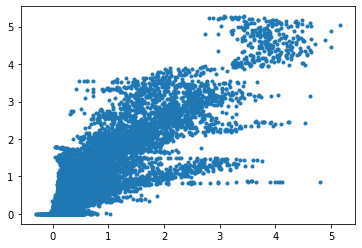

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.4396 - ExpID_loss: 2.8495 - Y_output_loss: 0.4394 - val_loss: 0.3514 - val_ExpID_loss: 2.8482 - val_Y_output_loss: 0.3511
Epoch 4/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.3666 - ExpID_loss: 2.8591 - Y_output_loss: 0.3666

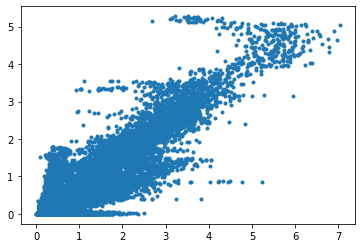

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.3666 - ExpID_loss: 2.8597 - Y_output_loss: 0.3667 - val_loss: 0.4398 - val_ExpID_loss: 2.8631 - val_Y_output_loss: 0.4393
Epoch 5/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.3359 - ExpID_loss: 2.8598 - Y_output_loss: 0.3359

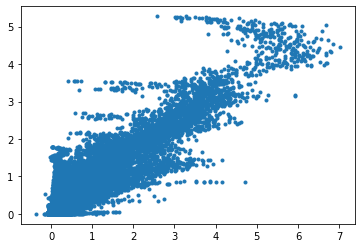

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.3359 - ExpID_loss: 2.8597 - Y_output_loss: 0.3360 - val_loss: 0.3310 - val_ExpID_loss: 2.8461 - val_Y_output_loss: 0.3305
Epoch 6/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.3082 - ExpID_loss: 2.8651 - Y_output_loss: 0.3082

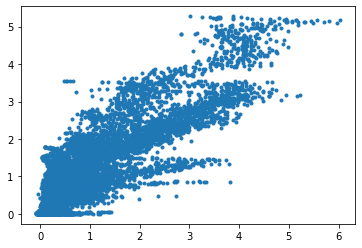

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.3080 - ExpID_loss: 2.8650 - Y_output_loss: 0.3077 - val_loss: 0.3033 - val_ExpID_loss: 2.8504 - val_Y_output_loss: 0.3029
Epoch 7/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.2985 - ExpID_loss: 2.8744 - Y_output_loss: 0.2985

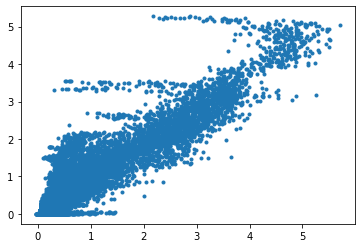

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.2984 - ExpID_loss: 2.8746 - Y_output_loss: 0.2981 - val_loss: 0.2442 - val_ExpID_loss: 2.8614 - val_Y_output_loss: 0.2438
Epoch 8/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.2687 - ExpID_loss: 2.8744 - Y_output_loss: 0.2687

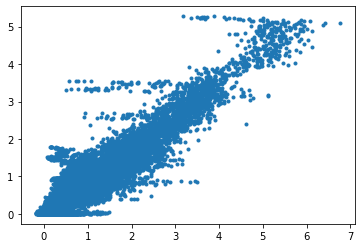

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.2687 - ExpID_loss: 2.8743 - Y_output_loss: 0.2686 - val_loss: 0.2506 - val_ExpID_loss: 2.8515 - val_Y_output_loss: 0.2504
Epoch 9/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.2480 - ExpID_loss: 2.8779 - Y_output_loss: 0.2480

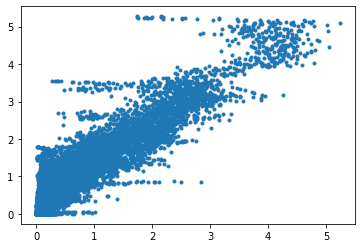

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.2480 - ExpID_loss: 2.8794 - Y_output_loss: 0.2479 - val_loss: 0.2734 - val_ExpID_loss: 2.8794 - val_Y_output_loss: 0.2732
Epoch 10/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.2329 - ExpID_loss: 2.8782 - Y_output_loss: 0.2329

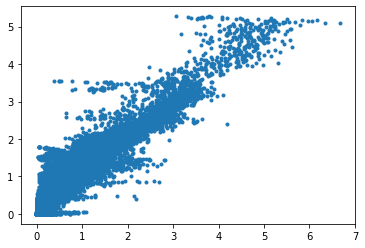

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.2329 - ExpID_loss: 2.8782 - Y_output_loss: 0.2329 - val_loss: 0.2252 - val_ExpID_loss: 2.8714 - val_Y_output_loss: 0.2250
Epoch 11/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.2142 - ExpID_loss: 2.8769 - Y_output_loss: 0.2142

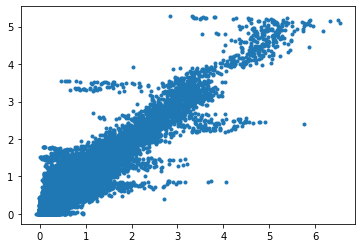

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.2143 - ExpID_loss: 2.8769 - Y_output_loss: 0.2144 - val_loss: 0.2203 - val_ExpID_loss: 2.8517 - val_Y_output_loss: 0.2201
Epoch 12/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.2247 - ExpID_loss: 2.8683 - Y_output_loss: 0.2247

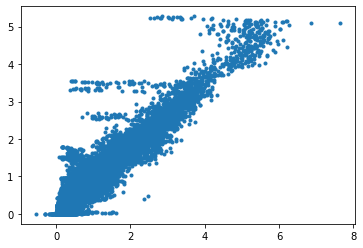

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.2247 - ExpID_loss: 2.8683 - Y_output_loss: 0.2248 - val_loss: 0.2139 - val_ExpID_loss: 2.8569 - val_Y_output_loss: 0.2135
Epoch 13/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.2195 - ExpID_loss: 2.8689 - Y_output_loss: 0.2195

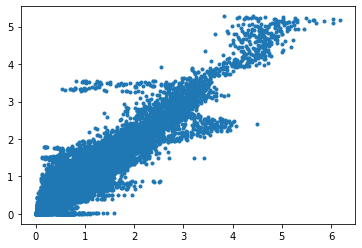

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.2195 - ExpID_loss: 2.8688 - Y_output_loss: 0.2195 - val_loss: 0.2015 - val_ExpID_loss: 2.8633 - val_Y_output_loss: 0.2014
Epoch 14/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.2134 - ExpID_loss: 2.8710 - Y_output_loss: 0.2134

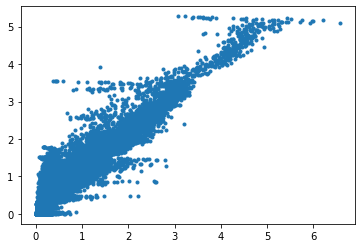

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.2135 - ExpID_loss: 2.8710 - Y_output_loss: 0.2136 - val_loss: 0.1959 - val_ExpID_loss: 2.8718 - val_Y_output_loss: 0.1955
Epoch 15/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.2093 - ExpID_loss: 2.8655 - Y_output_loss: 0.2093

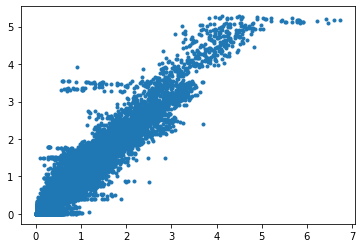

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.2094 - ExpID_loss: 2.8655 - Y_output_loss: 0.2096 - val_loss: 0.1894 - val_ExpID_loss: 2.8445 - val_Y_output_loss: 0.1892
Epoch 16/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.2001 - ExpID_loss: 2.8601 - Y_output_loss: 0.2001

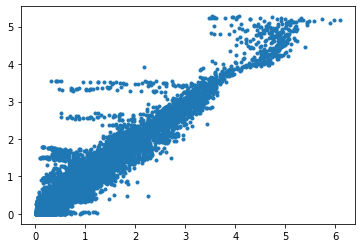

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.2000 - ExpID_loss: 2.8602 - Y_output_loss: 0.1998 - val_loss: 0.1614 - val_ExpID_loss: 2.8525 - val_Y_output_loss: 0.1612
Epoch 17/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.2020 - ExpID_loss: 2.8610 - Y_output_loss: 0.2020

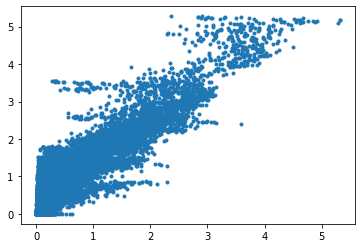

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.2020 - ExpID_loss: 2.8610 - Y_output_loss: 0.2021 - val_loss: 0.2943 - val_ExpID_loss: 2.8516 - val_Y_output_loss: 0.2942
Epoch 18/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.2102 - ExpID_loss: 2.8604 - Y_output_loss: 0.2102

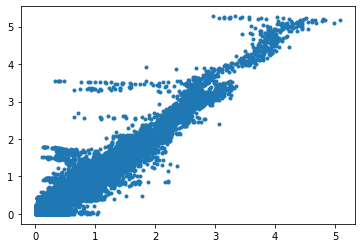

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.2102 - ExpID_loss: 2.8602 - Y_output_loss: 0.2102 - val_loss: 0.1698 - val_ExpID_loss: 2.8499 - val_Y_output_loss: 0.1697
Epoch 19/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1962 - ExpID_loss: 2.8571 - Y_output_loss: 0.1962

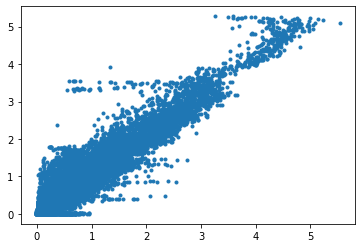

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1964 - ExpID_loss: 2.8571 - Y_output_loss: 0.1966 - val_loss: 0.1937 - val_ExpID_loss: 2.8590 - val_Y_output_loss: 0.1934
Epoch 20/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1964 - ExpID_loss: 2.8552 - Y_output_loss: 0.1964

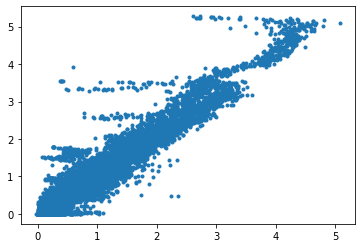

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1963 - ExpID_loss: 2.8552 - Y_output_loss: 0.1963 - val_loss: 0.1635 - val_ExpID_loss: 2.8512 - val_Y_output_loss: 0.1633
Epoch 21/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1939 - ExpID_loss: 2.8619 - Y_output_loss: 0.1939

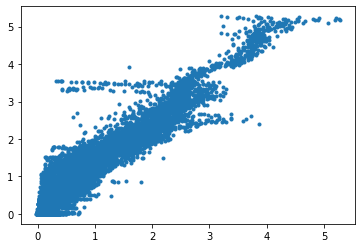

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1939 - ExpID_loss: 2.8619 - Y_output_loss: 0.1938 - val_loss: 0.2369 - val_ExpID_loss: 2.8707 - val_Y_output_loss: 0.2366
Epoch 22/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.2031 - ExpID_loss: 2.8610 - Y_output_loss: 0.2031

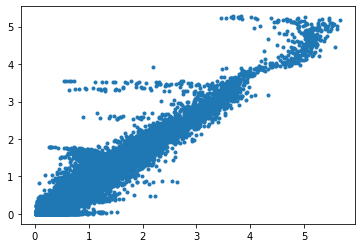

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.2031 - ExpID_loss: 2.8608 - Y_output_loss: 0.2031 - val_loss: 0.2037 - val_ExpID_loss: 2.8485 - val_Y_output_loss: 0.2034
Epoch 23/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.2027 - ExpID_loss: 2.8585 - Y_output_loss: 0.2027

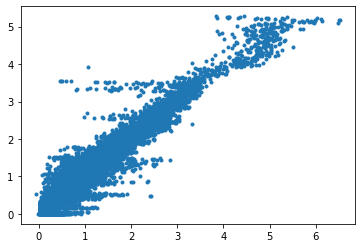

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.2027 - ExpID_loss: 2.8584 - Y_output_loss: 0.2027 - val_loss: 0.1559 - val_ExpID_loss: 2.8432 - val_Y_output_loss: 0.1557
Epoch 24/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1896 - ExpID_loss: 2.8557 - Y_output_loss: 0.1896

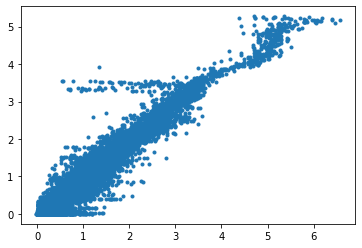

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1896 - ExpID_loss: 2.8556 - Y_output_loss: 0.1896 - val_loss: 0.1626 - val_ExpID_loss: 2.8485 - val_Y_output_loss: 0.1624
Epoch 25/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.2011 - ExpID_loss: 2.8594 - Y_output_loss: 0.2011

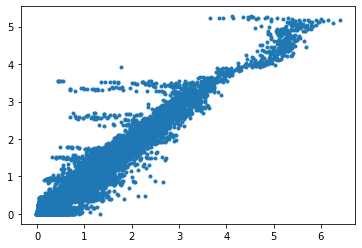

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.2011 - ExpID_loss: 2.8593 - Y_output_loss: 0.2009 - val_loss: 0.1664 - val_ExpID_loss: 2.8535 - val_Y_output_loss: 0.1665
Epoch 26/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1917 - ExpID_loss: 2.8572 - Y_output_loss: 0.1917

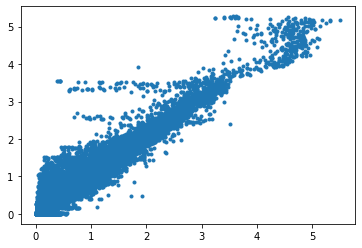

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1917 - ExpID_loss: 2.8572 - Y_output_loss: 0.1916 - val_loss: 0.1675 - val_ExpID_loss: 2.8393 - val_Y_output_loss: 0.1674
Epoch 27/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1877 - ExpID_loss: 2.8579 - Y_output_loss: 0.1877

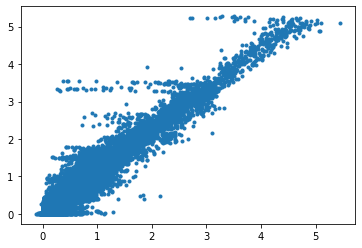

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1876 - ExpID_loss: 2.8578 - Y_output_loss: 0.1875 - val_loss: 0.2031 - val_ExpID_loss: 2.8640 - val_Y_output_loss: 0.2029
Epoch 28/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1886 - ExpID_loss: 2.8597 - Y_output_loss: 0.1886

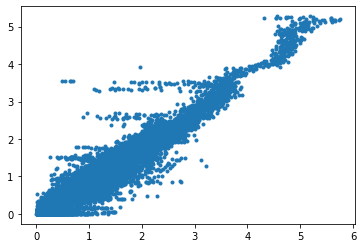

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1886 - ExpID_loss: 2.8596 - Y_output_loss: 0.1885 - val_loss: 0.1907 - val_ExpID_loss: 2.8739 - val_Y_output_loss: 0.1903
Epoch 29/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1885 - ExpID_loss: 2.8602 - Y_output_loss: 0.1885

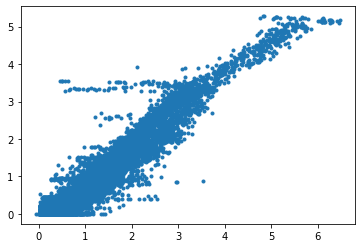

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1884 - ExpID_loss: 2.8601 - Y_output_loss: 0.1883 - val_loss: 0.2407 - val_ExpID_loss: 2.8622 - val_Y_output_loss: 0.2406
Epoch 30/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1887 - ExpID_loss: 2.8602 - Y_output_loss: 0.1887

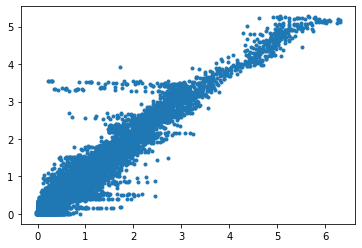

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1888 - ExpID_loss: 2.8601 - Y_output_loss: 0.1890 - val_loss: 0.1584 - val_ExpID_loss: 2.8451 - val_Y_output_loss: 0.1582
Epoch 31/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1938 - ExpID_loss: 2.8596 - Y_output_loss: 0.1938

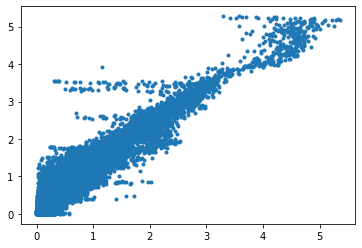

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1938 - ExpID_loss: 2.8596 - Y_output_loss: 0.1938 - val_loss: 0.2036 - val_ExpID_loss: 2.8641 - val_Y_output_loss: 0.2035
Epoch 32/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1897 - ExpID_loss: 2.8616 - Y_output_loss: 0.1897

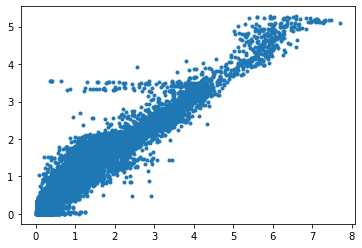

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1895 - ExpID_loss: 2.8619 - Y_output_loss: 0.1893 - val_loss: 0.2217 - val_ExpID_loss: 2.8719 - val_Y_output_loss: 0.2213
Epoch 33/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1899 - ExpID_loss: 2.8640 - Y_output_loss: 0.1899Restoring model weights from the end of the best epoch.


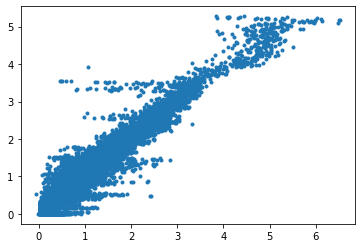

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1899 - ExpID_loss: 2.8642 - Y_output_loss: 0.1898 - val_loss: 0.2005 - val_ExpID_loss: 2.8756 - val_Y_output_loss: 0.2002
Epoch 34/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.2131 - ExpID_loss: 2.8536 - Y_output_loss: 0.2131Restoring model weights from the end of the best epoch.


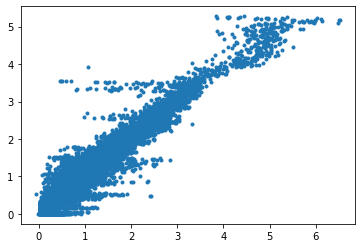

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.2132 - ExpID_loss: 2.8536 - Y_output_loss: 0.2133 - val_loss: 0.1940 - val_ExpID_loss: 2.8975 - val_Y_output_loss: 0.1940
Epoch 35/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1950 - ExpID_loss: 2.8571 - Y_output_loss: 0.1950Restoring model weights from the end of the best epoch.


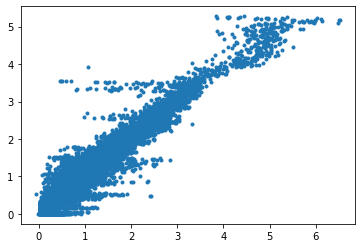

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1951 - ExpID_loss: 2.8573 - Y_output_loss: 0.1952 - val_loss: 0.1819 - val_ExpID_loss: 2.8757 - val_Y_output_loss: 0.1818
Epoch 36/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1963 - ExpID_loss: 2.8578 - Y_output_loss: 0.1963Restoring model weights from the end of the best epoch.


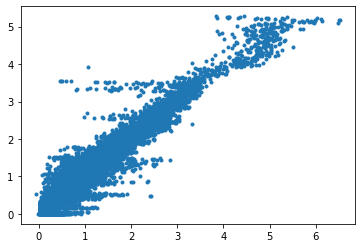

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1963 - ExpID_loss: 2.8579 - Y_output_loss: 0.1963 - val_loss: 0.1629 - val_ExpID_loss: 2.8525 - val_Y_output_loss: 0.1628
Epoch 37/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1930 - ExpID_loss: 2.8581 - Y_output_loss: 0.1930Restoring model weights from the end of the best epoch.


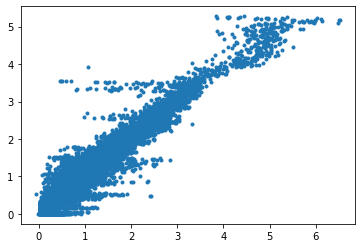

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1929 - ExpID_loss: 2.8581 - Y_output_loss: 0.1928 - val_loss: 0.1829 - val_ExpID_loss: 2.8546 - val_Y_output_loss: 0.1827
Epoch 38/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.2038 - ExpID_loss: 2.8584 - Y_output_loss: 0.2038Restoring model weights from the end of the best epoch.


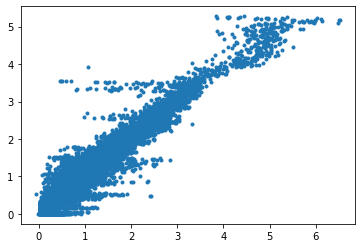

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.2038 - ExpID_loss: 2.8585 - Y_output_loss: 0.2038 - val_loss: 0.2259 - val_ExpID_loss: 2.8466 - val_Y_output_loss: 0.2257
Epoch 39/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1931 - ExpID_loss: 2.8523 - Y_output_loss: 0.1931Restoring model weights from the end of the best epoch.


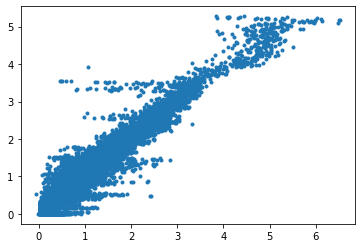

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1931 - ExpID_loss: 2.8522 - Y_output_loss: 0.1930 - val_loss: 0.1594 - val_ExpID_loss: 2.8545 - val_Y_output_loss: 0.1592
Epoch 40/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1961 - ExpID_loss: 2.8576 - Y_output_loss: 0.1961Restoring model weights from the end of the best epoch.


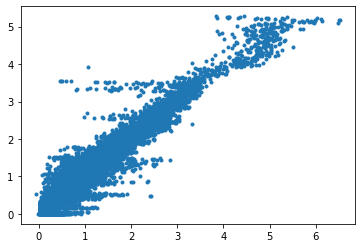

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1960 - ExpID_loss: 2.8577 - Y_output_loss: 0.1959 - val_loss: 0.1974 - val_ExpID_loss: 2.8543 - val_Y_output_loss: 0.1973
Epoch 41/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1985 - ExpID_loss: 2.8566 - Y_output_loss: 0.1985Restoring model weights from the end of the best epoch.


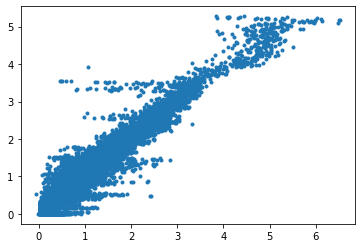

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1985 - ExpID_loss: 2.8566 - Y_output_loss: 0.1985 - val_loss: 0.1901 - val_ExpID_loss: 2.8463 - val_Y_output_loss: 0.1900
Epoch 42/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1904 - ExpID_loss: 2.8600 - Y_output_loss: 0.1904Restoring model weights from the end of the best epoch.


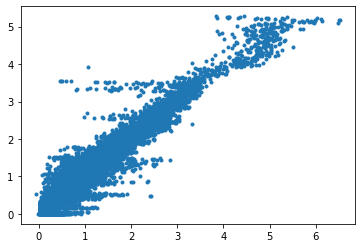

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1904 - ExpID_loss: 2.8599 - Y_output_loss: 0.1905 - val_loss: 0.1843 - val_ExpID_loss: 2.8613 - val_Y_output_loss: 0.1841
Epoch 43/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1942 - ExpID_loss: 2.8616 - Y_output_loss: 0.1942Restoring model weights from the end of the best epoch.


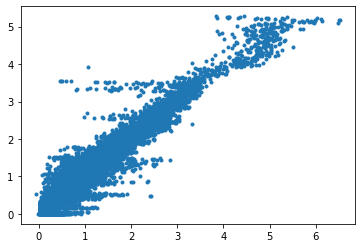

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1941 - ExpID_loss: 2.8616 - Y_output_loss: 0.1940 - val_loss: 0.2036 - val_ExpID_loss: 2.8588 - val_Y_output_loss: 0.2033
Epoch 44/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1902 - ExpID_loss: 2.8606 - Y_output_loss: 0.1902Restoring model weights from the end of the best epoch.


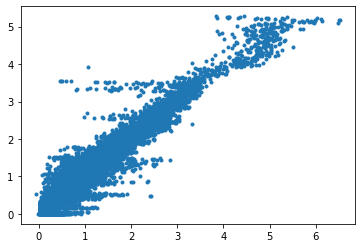

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1902 - ExpID_loss: 2.8605 - Y_output_loss: 0.1902 - val_loss: 0.2273 - val_ExpID_loss: 2.8507 - val_Y_output_loss: 0.2272
Epoch 45/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1897 - ExpID_loss: 2.8526 - Y_output_loss: 0.1897Restoring model weights from the end of the best epoch.


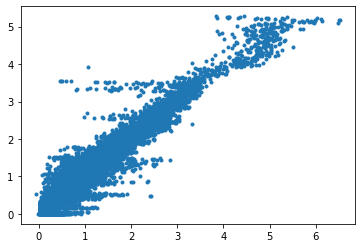

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1896 - ExpID_loss: 2.8526 - Y_output_loss: 0.1896 - val_loss: 0.2152 - val_ExpID_loss: 2.8629 - val_Y_output_loss: 0.2152
Epoch 46/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.2012 - ExpID_loss: 2.8656 - Y_output_loss: 0.2012Restoring model weights from the end of the best epoch.


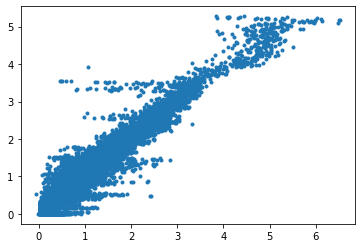

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.2012 - ExpID_loss: 2.8656 - Y_output_loss: 0.2012 - val_loss: 0.2516 - val_ExpID_loss: 2.8574 - val_Y_output_loss: 0.2513
Epoch 47/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1921 - ExpID_loss: 2.8579 - Y_output_loss: 0.1921Restoring model weights from the end of the best epoch.


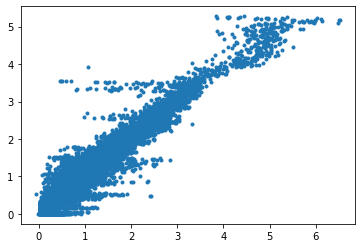

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1921 - ExpID_loss: 2.8579 - Y_output_loss: 0.1923 - val_loss: 0.1774 - val_ExpID_loss: 2.8606 - val_Y_output_loss: 0.1773
Epoch 48/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1968 - ExpID_loss: 2.8602 - Y_output_loss: 0.1968Restoring model weights from the end of the best epoch.


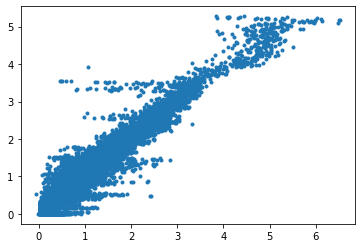

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1968 - ExpID_loss: 2.8600 - Y_output_loss: 0.1968 - val_loss: 0.2198 - val_ExpID_loss: 2.8609 - val_Y_output_loss: 0.2196
Epoch 49/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1916 - ExpID_loss: 2.8586 - Y_output_loss: 0.1916Restoring model weights from the end of the best epoch.


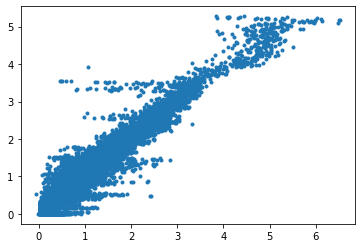

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1916 - ExpID_loss: 2.8586 - Y_output_loss: 0.1916 - val_loss: 0.1831 - val_ExpID_loss: 2.8619 - val_Y_output_loss: 0.1829
Epoch 50/50
16100/16119 [============================>.] - ETA: 0s - loss: 0.1982 - ExpID_loss: 2.8634 - Y_output_loss: 0.1982Restoring model weights from the end of the best epoch.


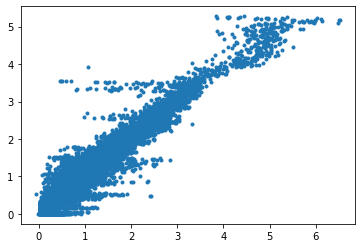

16119/16119 [==============================] - 46s 3ms/sample - loss: 0.1981 - ExpID_loss: 2.8632 - Y_output_loss: 0.1980 - val_loss: 0.2194 - val_ExpID_loss: 2.8337 - val_Y_output_loss: 0.2191
Epoch 00050: early stopping


In [185]:

epochs = 50; #training_parameters["nepochs"]
batchsize =50;
if (tf.__version__ == '2.1.0'):
    confusion_matrix = tf.compat.v1.math.confusion_matrix
else:
    from tensorflow.math import confusion_matrix
    
import tensorflow.keras as keras
from tensorflow.keras import layers 

LRATE_MIN = 0.001;
LRATE_MAX = 0.005;
BURNIN_EPOCHS = 5;

c_loss =0.0;
CLOSS_MAX = 0.1;

es = keras.callbacks.EarlyStopping(monitor='val_Y_output_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)
model_opt = keras.optimizers.Adam(learning_rate=0.0);



class Top3AccStrong(tf.keras.callbacks.Callback):
    def __init__(self):
        self.top3acc_strong = []
    def on_epoch_end(self,epoch,logs = None):
        top3acc, cmatrix_strong = plot_cmatrix_strong_return_top3acc(leave_exp_out, epoch, 0.001,root_folder = "/tmp")
        self.top3acc_strong.append(top3acc)

class plot_PCA(tf.keras.callbacks.Callback):
    def __init__(self):
        None
    def on_epoch_end(self,epoch,logs = None):
        a,b = get_vv_vals()
        pp = PCA(n_components=2).fit_transform((a - np.mean(a,0)) /np.std(a))
        pplot.scatter(pp[:,0], pp[:,1],c = b)
        pplot.show()
        #top3acc = plot_cmatrix_strong_return_top3acc(leave_exp_out, epoch, 0.001,root_folder = "/tmp")
        
class plot_fit(tf.keras.callbacks.Callback):
    def __init__(self):
        None
        
    def on_epoch_end(self,epoch, logs = None):
        yhat = model.predict(x_train, batch_size = 100)
        pplot.cla()
        pplot.plot(yhat[1], y_train,'.')
        pplot.show()
        
class BurnIn(tf.keras.callbacks.Callback):
    def __init__(self, burnin_epochs = None, lrate_max = LRATE_MAX):
        self.learning_rate = lrate_max
        self.burnin_epochs = burnin_epochs
        
    def on_epoch_end(self,epoch, logs = None):
        if epoch <= self.burnin_epochs:
            de = epoch/self.burnin_epochs
            lrate = de * self.learning_rate
            if lrate < LRATE_MIN:
                model_opt.learning_rate = LRATE_MIN
            else:
                model_opt.learning_rate = de * self.learning_rate

def top3_acc(labels, logits):
    return keras.metrics.top_k_categorical_accuracy(labels,logits, k=3)


def plot_confusion():
    cmat = confusion_matrix(np.argmax(Yoh,1),np.argmax(Yhat,1))
    pplot.pcolor(cmat.eval())
    pplot.show()


loss_fcn = {"Y_output" :lambda y,yhat : tf.reduce_mean(tf.abs(y-yhat)), #*1/(0.1+abs(y)*1.5)),
            "ExpID" : lambda y,yhat : tf.compat.v1.losses.softmax_cross_entropy(y,yhat),
           }

loss_w = {"Y_output": 1.,"ExpID" : closs}

# GOAL: Maximize the loss of the domain critic while maximizing the actual predictor.

# useful discriminator:
model.compile(optimizer =  model_opt,
              loss =loss_fcn,
              loss_weights = loss_w)

train_in, train_out = [{"timeseries_input": x_train},{"Y_output":y_train,
                                                     "ExpID" : d_train}]
test_in, test_out = [{"timeseries_input": x_test},{"Y_output":y_test,
                                                     "ExpID" : d_test}]

#test_in, test_out = [{"timeseries_input" : Xstrong}, {"Y_output" : YstrongOH, "ExpID" : np.zeros([YstrongOH.shape[0],3])}]
burnin = BurnIn(burnin_epochs = BURNIN_EPOCHS, lrate_max = LRATE_MAX)
history_d = model.fit(train_in, train_out, epochs=epochs,
                     batch_size=batchsize,
                      validation_data = [test_in, test_out],# "Rc_output" :  RemCTest}],
                     callbacks=[es, burnin, plot_fit()])#, Top3AccStrong()])#, InspectActivations()]);#, Top3AccStrong()])




{'inputs': [{'type': 'timeseries',
   'help_string': '(required) the timeseries input for the layer.',
   'id': 'timeseries_input',
   'shape': (2559, 2)}],
 'densenet_1d': {'network_layers': [{'type': 'densenet_block',
    'id': 'DN1',
    'help_string': 'Parametrization for a `densenet_block`',
    'params': {'filters': [50, 50, 50, 50],
     'dilation_rates': [2, 4, 8, 16],
     'kernel_sizes': [3, 3, 3, 3],
     'Variational': False,
     'dropout_after_composite': 0.1,
     'internal_bottleneck_factor': 1}},
   {'type': 'final_pooling', 'id': 'FinalPooling'}]},
 'domain_classifier': {'network_layers': [{'type': 'Dense',
    'params': {'units': 100, 'activation': 'relu', 'use_bias': True}},
   {'type': 'Dropout', 'params': {'rate': 0.2}},
   {'type': 'Dense',
    'id': 'domain_output',
    'params': {'units': 17, 'name': 'ExpID'}}]},
 'classifier': {'network_layers': [{'type': 'Dense',
    'params': {'units': 640, 'activation': 'relu', 'use_bias': True}},
   {'type': 'Dropout', 'pa

In [143]:

import datetime
d = datetime.datetime.now()
closs = 0;
folder = d.strftime("{0:s}_%d-%m-%y_%T_closs{1:2.3f}".format("Dilated_DenseNet",closs))

write_folder = os.path.join(os.path.curdir,"saved_models", folder);

os.mkdir(write_folder)
model.save_weights(os.path.join(write_folder, "weights.bin"))
with open(os.path.join(write_folder, "model_spec.json"),'w') as f:
    f.write(json.dumps(model_json, indent = 4))
#!mkdir saved_moels
#model.save_weights()


In [147]:
!tree saved_models/

saved_models/
└── Dilated_DenseNet_05-03-20_18:04:51_closs0.000
    ├── checkpoint
    ├── model_spec.json
    ├── weights.bin.data-00000-of-00002
    ├── weights.bin.data-00001-of-00002
    └── weights.bin.index

1 directory, 5 files


'./saved_models/Dilated_DenseNet_05-03-20_18:00:07_closs0.000/model_spec.json'

In [133]:
!ls saved_models/Dilated_DenseNet_05-03-20_17\:55\:33_closs0.000/

checkpoint			 weights.bin.data-00001-of-00002
weights.bin.data-00000-of-00002  weights.bin.index


In [128]:
#import json
#json.dumps(model_json,%precision)
#help(json.dumps)
json.dumps(model_json, indent = 4)


'{\n    "inputs": [\n        {\n            "type": "timeseries",\n            "help_string": "(required) the timeseries input for the layer.",\n            "id": "timeseries_input",\n            "shape": [\n                2559,\n                2\n            ]\n        }\n    ],\n    "densenet_1d": {\n        "network_layers": [\n            {\n                "type": "densenet_block",\n                "id": "DN1",\n                "help_string": "Parametrization for a `densenet_block`",\n                "params": {\n                    "filters": [\n                        50,\n                        50,\n                        50,\n                        50\n                    ],\n                    "dilation_rates": [\n                        2,\n                        4,\n                        8,\n                        16\n                    ],\n                    "kernel_sizes": [\n                        3,\n                        3,\n                        3,\n 

In [ ]:
pplot.plot(history_d.history['loss'])
pplot.plot(history_d.history['val_loss'])

In [125]:
#X[:,0]
import scipy
@interact(ii = IntSlider(min = 0 , max = 2000),ii2 = IntSlider(min = 0 , max = 2000), ee = IntSlider(min = 0, max = 16), nperseg = IntSlider(min = 64, max = 512))
def aa_(ii,ii2,ee,nperseg):
    x = X[eid == ee];
    print(len(x))
    #scipy.signal.fft(X[:,0])
    if ii2 > len(x): ii2 = len(x)-1
    if ii > len(x): ii = len(x)-1
    s1 = np.abs(scipy.signal.stft(x[ii][:,1],nperseg = nperseg)[2])
    s2 = np.abs(scipy.signal.stft(x[ii2][:,1],nperseg = nperseg)[2])
    pplot.pcolor(np.hstack([s1,s2]))
        

interactive(children=(IntSlider(value=0, description='ii', max=2000), IntSlider(value=0, description='ii2', ma…

In [145]:
all_files

['AccB_2_7.pickle',
 'AccB_1_7.pickle',
 'AccB_3_2.pickle',
 'AccB_3_1.pickle',
 'AccB_1_2.pickle',
 'AccB_1_3.pickle',
 'AccB_1_5.pickle',
 'AccB_2_3.pickle',
 'AccB_1_4.pickle',
 'AccB_2_5.pickle',
 'AccB_2_6.pickle',
 'AccB_3_3.pickle',
 'AccB_2_2.pickle',
 'AccB_2_1.pickle',
 'AccB_2_4.pickle',
 'AccB_1_1.pickle',
 'AccB_1_6.pickle']

In [150]:
locals()

{'__name__': '__main__',
 '__doc__': 'Automatically created module for IPython interactive environment',
 '__package__': None,
 '__loader__': None,
 '__spec__': None,
 '__builtin__': <module 'builtins' (built-in)>,
 '__builtins__': <module 'builtins' (built-in)>,
 '_ih': ['',
  "get_ipython().system('ls bearing_fatigue_dataset/')",
  'import tensorflow as tf\n#tf.enable_eager_execution()\nimport tensorflow.keras as keras\nimport numpy as np\nimport matplotlib.pyplot as pplot\nfrom tensorflow.keras import Model\nfrom tensorflow.keras.layers import Input, Dense, Conv1D, AveragePooling1D, GlobalAveragePooling1D, Flatten, BatchNormalization, Dropout\n\nimport os\n\nfrom tensorflow.compat.v1 import ConfigProto\nfrom tensorflow.compat.v1 import InteractiveSession\nconfig = ConfigProto()\nconfig.gpu_options.allow_growth = True\nsess = InteractiveSession(config=config)\n#tf.keras.backend.set_session(sess)\n#from tensorflow.math import confusion_matrix',
  'tf.__version__',
  'from src.dilated_

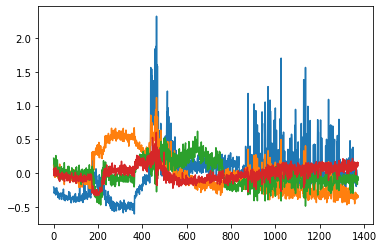

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 4)
y = pca.fit_transform(np.vstack([np.mean(z0,1),np.mean(z1,1)]))
pplot.plot(y)

In [37]:
del z0,z1
z0 = inspect_ddout.predict(X[eid == 1],batch_size = 20)
z1 = inspect_ddout.predict(X[eid == 5], batch_size = 20)

MemoryError: Unable to allocate array with shape (1802, 2559, 400) and data type float32

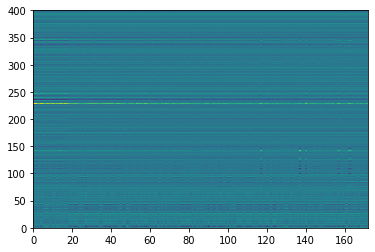

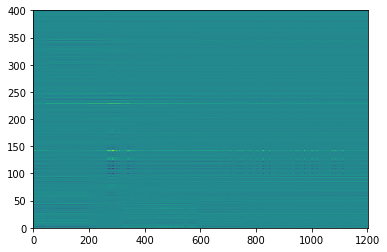

In [28]:
pplot.pcolor(np.mean(z0,1).T)
pplot.show()
pplot.pcolor(np.mean(z1,1).T)


In [23]:
inspect_ddout = Model(inputs = model.get_layer("timeseries_input").input,outputs = model.get_layer("DN_DN1_Out").output)
#inspect_ddout.predict()

In [63]:
#np.sum(y_train < 1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
timeseries_input (InputLayer)   [(None, 2559, 2)]    0                                            
__________________________________________________________________________________________________
DN_DN1_C1D (Conv1D)             (None, 2559, 50)     150         timeseries_input[0][0]           
__________________________________________________________________________________________________
DN_DN1_idx_0 (Sequential)       (None, 2559, 50)     15100       DN_DN1_C1D[0][0]                 
__________________________________________________________________________________________________
DN_DN1_idx_1 (Sequential)       (None, 2559, 50)     15100       DN_DN1_idx_0[0][0]               
                                                                 DN_DN1_C1D[0][0]             

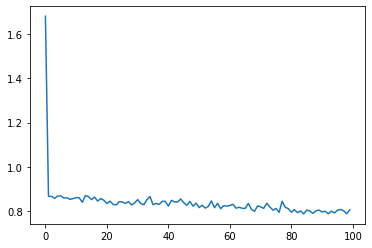

In [57]:
pplot.plot(history_d.history['val_Y_output_loss'])
#pplot.plot(history_d.history['loss'])
#pplot.savefig("asdf.png")


asdf.png
